In [23]:
import umap
import haloflow.data as D
from haloflow.dann.model import DANNModel
from haloflow.config import get_dat_dir
from haloflow.mmd.models import MMDModel

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [2]:
X = []
domains = []

In [3]:
for sim in ['TNG_ALL', 'Eagle100', 'Simba100']:
    _, X_t = D.hf2_centrals("all", obs='mags_morph_extra', sim=sim)
    X.append(X_t)
    domains.append(np.full(X_t.shape[0], sim))

In [4]:
X = np.concatenate(X)
domains = np.concatenate(domains)

In [5]:
X.shape, domains.shape

((34920, 55), (34920,))

In [6]:
domains

array(['TNG_ALL', 'TNG_ALL', 'TNG_ALL', ..., 'Simba100', 'Simba100',
       'Simba100'], dtype='<U8')

# UMAP before DANN

In [53]:
# initialize
reducer_before = umap.UMAP(n_neighbors=25,
                            min_dist=0.1,
                            n_components=2,
                            n_jobs=6,
                            verbose=True)

In [54]:
# Fit and transform the features
embedding_before = reducer_before.fit_transform(X)

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(n_jobs=6, n_neighbors=25, verbose=True)
Mon Jul  7 23:05:46 2025 Construct fuzzy simplicial set
Mon Jul  7 23:05:46 2025 Finding Nearest Neighbors
Mon Jul  7 23:05:46 2025 Building RP forest with 14 trees
Mon Jul  7 23:05:46 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jul  7 23:05:47 2025 Finished Nearest Neighbor Search
Mon Jul  7 23:05:47 2025 Construct embedding


Epochs completed:   6%| ▌          11/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  15%| █▌         30/200 [00:00]

	completed  20  /  200 epochs


Epochs completed:  27%| ██▋        54/200 [00:00]

	completed  40  /  200 epochs


Epochs completed:  35%| ███▌       70/200 [00:00]

	completed  60  /  200 epochs


Epochs completed:  46%| ████▌      91/200 [00:01]

	completed  80  /  200 epochs


Epochs completed:  56%| █████▋     113/200 [00:01]

	completed  100  /  200 epochs


Epochs completed:  68%| ██████▊    135/200 [00:01]

	completed  120  /  200 epochs


Epochs completed:  74%| ███████▍   149/200 [00:02]

	completed  140  /  200 epochs


Epochs completed:  86%| ████████▌  171/200 [00:02]

	completed  160  /  200 epochs


Epochs completed:  96%| █████████▌ 192/200 [00:02]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:02]

Mon Jul  7 23:05:51 2025 Finished embedding


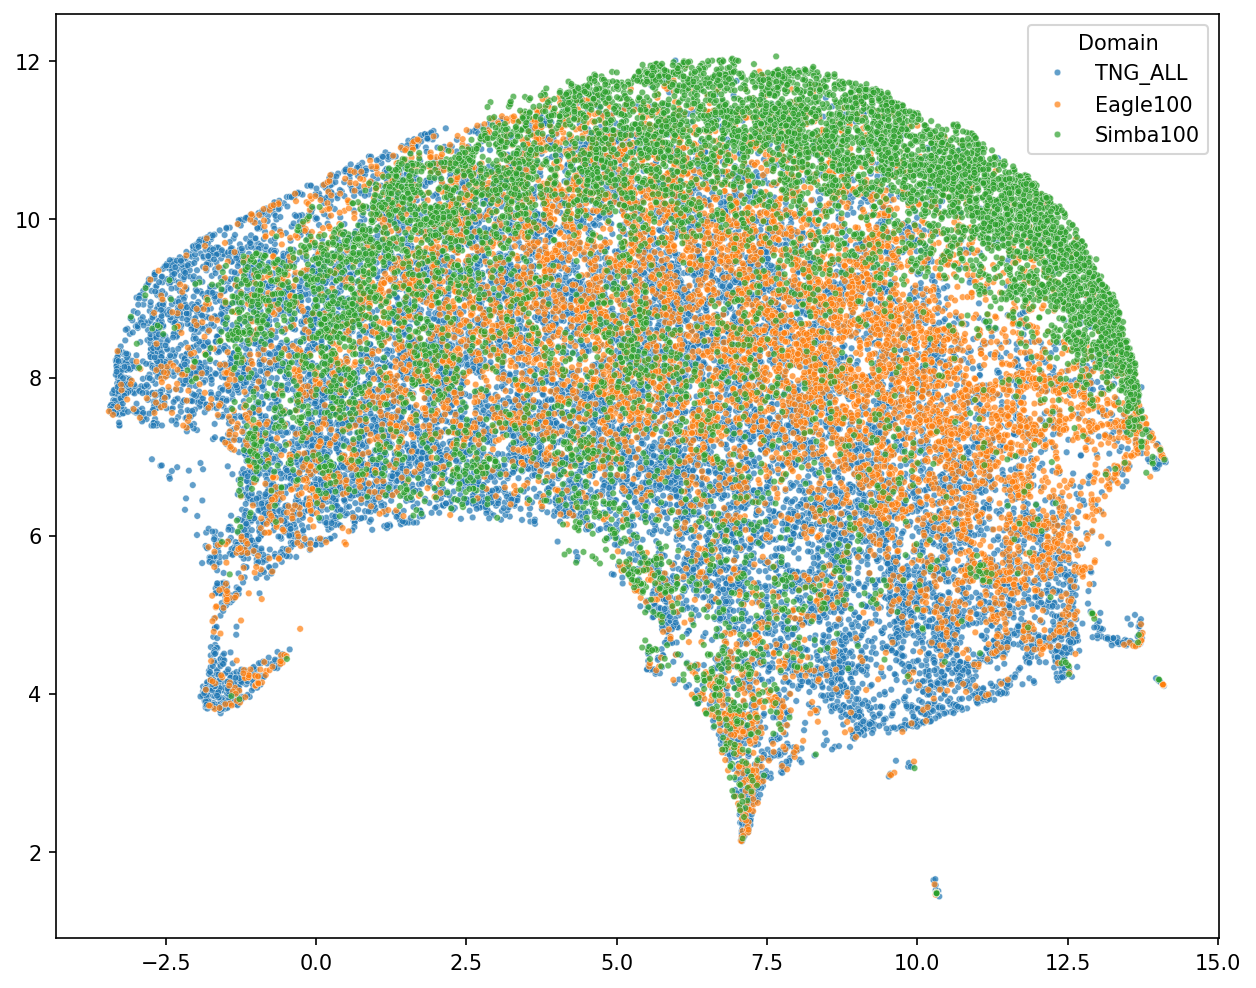

In [55]:
# Create DataFrame for plotting
df_umap_before = pd.DataFrame(embedding_before, columns=['UMAP1', 'UMAP2'])
df_umap_before['Domain'] = domains

# Plot 'Before' DANN
plt.figure(figsize=(10, 8), dpi=150)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Domain', palette='tab10', data=df_umap_before, s=10, alpha=0.7)
plt.xlabel('')
plt.ylabel('')  
plt.show()

# UMAP after DANN

In [35]:
dann_sim = 'TNG_ALL'

In [36]:
MODEL_NAME = f'dann_model_v3_to_{dann_sim}_mags_morph_extra'
FP = get_dat_dir() + f'hf2/dann/models/{MODEL_NAME}.pt'
FP_mean_std = get_dat_dir() + f'hf2/dann/models/{MODEL_NAME}_mean_std.npz'

In [37]:
input_dim = X.shape[1]
model = DANNModel(input_dim=input_dim).to('cpu')
model.load_state_dict(torch.load(FP, map_location='cpu'))

<All keys matched successfully>

In [38]:
array = np.load(FP_mean_std)
mean_, std_ = array['mean'], array['std']

In [39]:
X = (X - mean_) / std_
X_eval_tensor = torch.tensor(X, dtype=torch.float32).to('cpu')

In [40]:
model.eval()

DANNModel(
  (feature): Sequential(
    (fc1): Linear(in_features=55, out_features=128, bias=True)
    (silu1): SiLU()
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (silu2): SiLU()
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (silu3): SiLU()
  )
  (class_classifier): Sequential(
    (c_fc1): Linear(in_features=32, out_features=16, bias=True)
    (c_silu1): SiLU()
    (c_fc2): Linear(in_features=16, out_features=8, bias=True)
    (c_silu2): SiLU()
    (c_fc3): Linear(in_features=8, out_features=2, bias=True)
  )
  (domain_classifier): Sequential(
    (d_fc1): Linear(in_features=32, out_features=16, bias=True)
    (d_silu1): SiLU()
    (d_fc2): Linear(in_features=16, out_features=8, bias=True)
    (d_silu2): SiLU()
    (d_fc3): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [41]:
with torch.no_grad():
    X_feature_extractor_DANN = model.feature(X_eval_tensor).cpu().numpy()

In [56]:
# initialize
reducer_after = umap.UMAP(n_neighbors=25,
                            min_dist=0.1,
                            n_components=2,
                            n_jobs=6,
                            verbose=True)

# Fit and transform the features
embedding_after = reducer_after.fit_transform(X_feature_extractor_DANN)

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(n_jobs=6, n_neighbors=25, verbose=True)
Mon Jul  7 23:05:59 2025 Construct fuzzy simplicial set
Mon Jul  7 23:05:59 2025 Finding Nearest Neighbors
Mon Jul  7 23:05:59 2025 Building RP forest with 14 trees
Mon Jul  7 23:05:59 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Mon Jul  7 23:06:00 2025 Finished Nearest Neighbor Search
Mon Jul  7 23:06:00 2025 Construct embedding


Epochs completed:   6%| ▌          11/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  16%| █▌         31/200 [00:00]

	completed  20  /  200 epochs


Epochs completed:  28%| ██▊        55/200 [00:00]

	completed  40  /  200 epochs


Epochs completed:  36%| ███▌       71/200 [00:00]

	completed  60  /  200 epochs


Epochs completed:  48%| ████▊      95/200 [00:01]

	completed  80  /  200 epochs


Epochs completed:  56%| █████▌     111/200 [00:01]

	completed  100  /  200 epochs


Epochs completed:  68%| ██████▊    135/200 [00:01]

	completed  120  /  200 epochs


Epochs completed:  76%| ███████▌   151/200 [00:02]

	completed  140  /  200 epochs


Epochs completed:  88%| ████████▊  175/200 [00:02]

	completed  160  /  200 epochs


Epochs completed:  96%| █████████▌ 191/200 [00:02]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:02]

Mon Jul  7 23:06:05 2025 Finished embedding


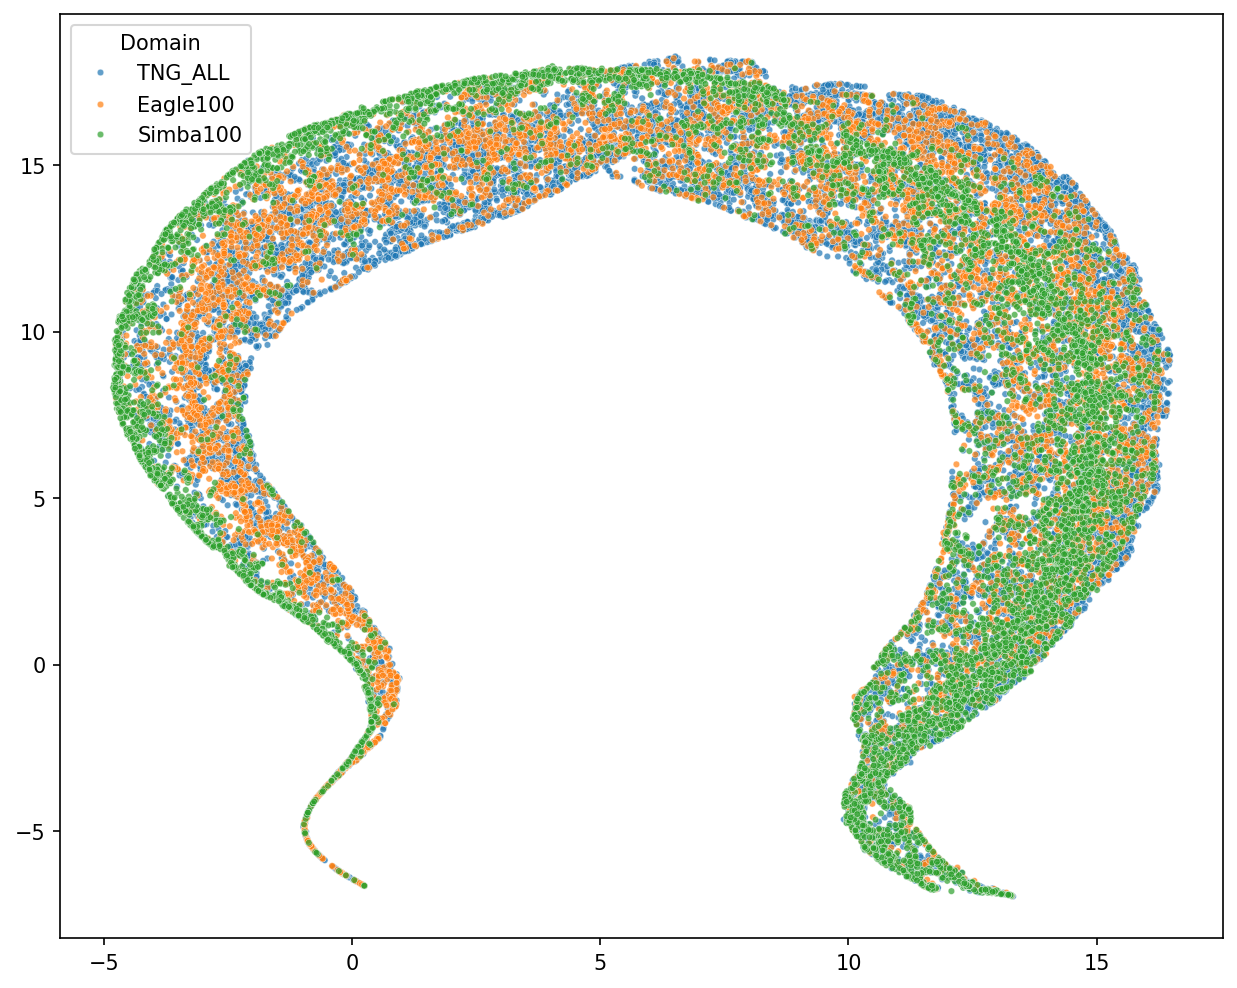

In [57]:
# Create DataFrame for plotting
df_umap_before = pd.DataFrame(embedding_after, columns=['UMAP1', 'UMAP2'])
df_umap_before['Domain'] = domains

# Plot 'Before' DANN
plt.figure(figsize=(10, 8), dpi=150)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Domain', palette='tab10', data=df_umap_before, s=10, alpha=0.7)
plt.xlabel('')
plt.ylabel('')
plt.show()

# UMAP with MMD

In [44]:
FP = get_dat_dir() + f'hf2/mmd/models/mmd_model_v2_to_{dann_sim}_mags_morph_extra.pt'

In [45]:
 # Load global mean and std normalization parameters
global_stats = np.load(get_dat_dir() + 'hf2/mmd/models/global_mean_std.npz', allow_pickle=True)
g_mean = global_stats['mean']
g_std = global_stats['std']

x_test_mmd = (X - g_mean) / g_std
X_eval_tensor_mmd = torch.tensor(x_test_mmd, dtype=torch.float32).to('cpu')

In [46]:
model = MMDModel(input_dim, output_dim=2)
model.load_state_dict(torch.load(FP))

model.eval()

MMDModel(
  (feature_extractor): FeatureExtractor(
    (fc1): Linear(in_features=55, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
    (relu): SiLU()
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (classifier): Classifier(
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=8, bias=True)
    (fc4): Linear(in_features=8, out_features=2, bias=True)
    (relu): SiLU()
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [47]:
with torch.no_grad():
    X_feature_extractor_MMD = model.feature_extractor(X_eval_tensor_mmd)

In [58]:
# initialize
reducer_after_mmd = umap.UMAP(n_neighbors=25,
                            min_dist=0.1,
                            n_components=2,
                            n_jobs=6,
                            verbose=True)

# Fit and transform the features
embedding_after_mmd = reducer_after_mmd.fit_transform(X_feature_extractor_DANN)

/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(n_jobs=6, n_neighbors=25, verbose=True)
Mon Jul  7 23:06:22 2025 Construct fuzzy simplicial set
Mon Jul  7 23:06:22 2025 Finding Nearest Neighbors
Mon Jul  7 23:06:22 2025 Building RP forest with 14 trees
Mon Jul  7 23:06:22 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Mon Jul  7 23:06:22 2025 Finished Nearest Neighbor Search
Mon Jul  7 23:06:23 2025 Construct embedding


Epochs completed:   6%| ▌          11/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  15%| █▌         30/200 [00:00]

	completed  20  /  200 epochs


Epochs completed:  27%| ██▋        54/200 [00:00]

	completed  40  /  200 epochs


Epochs completed:  35%| ███▌       70/200 [00:00]

	completed  60  /  200 epochs


Epochs completed:  47%| ████▋      94/200 [00:01]

	completed  80  /  200 epochs


Epochs completed:  55%| █████▌     110/200 [00:01]

	completed  100  /  200 epochs


Epochs completed:  67%| ██████▋    134/200 [00:01]

	completed  120  /  200 epochs


Epochs completed:  75%| ███████▌   150/200 [00:02]

	completed  140  /  200 epochs


Epochs completed:  87%| ████████▋  174/200 [00:02]

	completed  160  /  200 epochs


Epochs completed:  95%| █████████▌ 190/200 [00:02]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:02]

Mon Jul  7 23:06:27 2025 Finished embedding


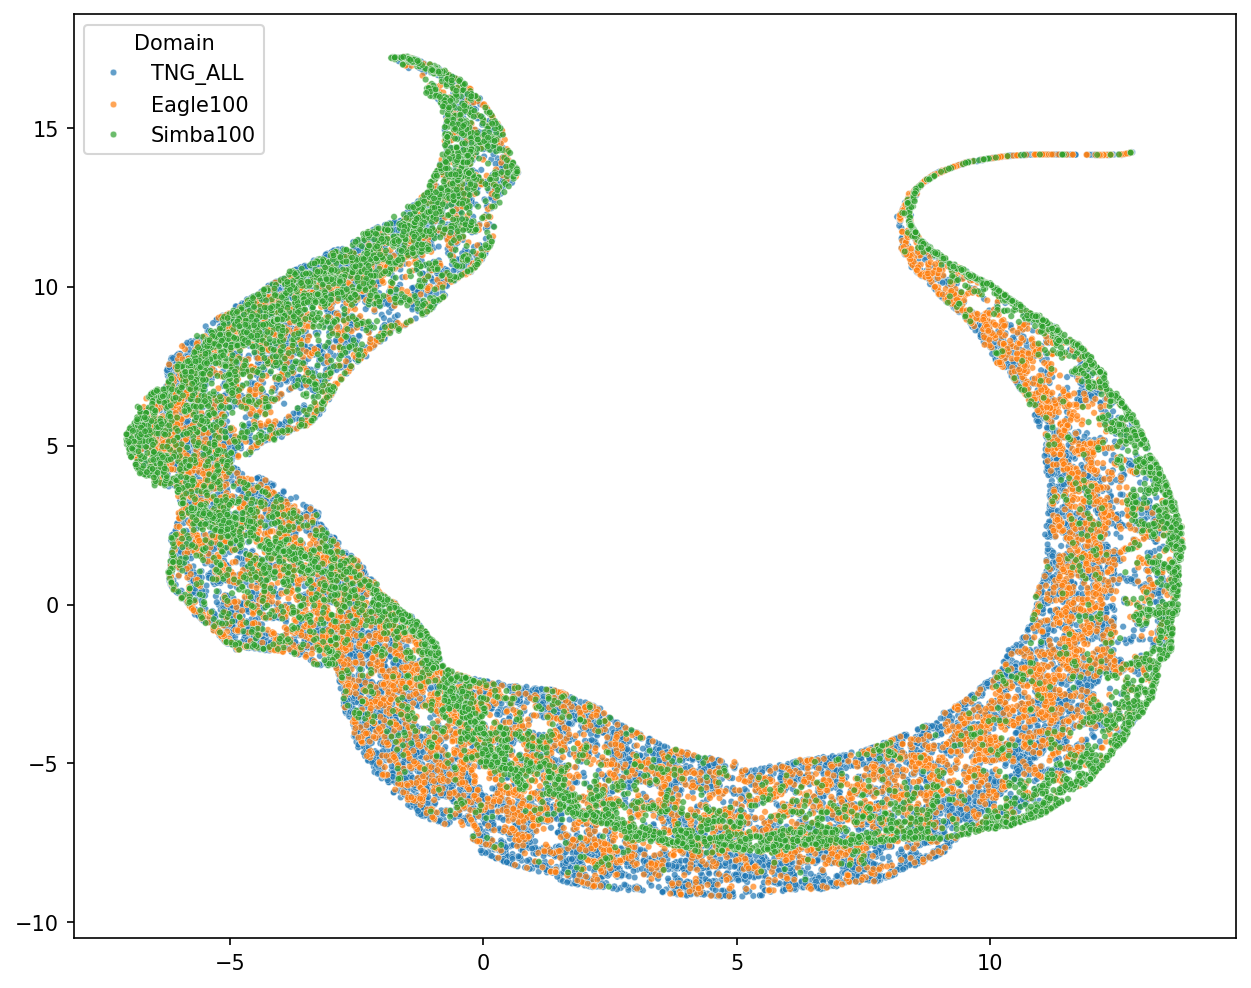

In [59]:
# Create DataFrame for plotting
df_umap_before = pd.DataFrame(embedding_after_mmd, columns=['UMAP1', 'UMAP2'])
df_umap_before['Domain'] = domains

# Plot 'Before' DANN
plt.figure(figsize=(10, 8), dpi=150)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Domain', palette='tab10', data=df_umap_before, s=10, alpha=0.7)
plt.xlabel('')
plt.ylabel('')
plt.show()